<a href="https://colab.research.google.com/github/jihyun923/city_change/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 79.3 MB/s eta 0:00:00


In [ ]:
!pip install import_ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.7 MB/s eta 0:00:00


[INFO] Using device: cpu
[INFO] in_channels from weight = 3

Starting prediction...
Image size: 2320 x 2010
Channels: 3
Data type: float32
Sample values - Min: 97.43487548828125, Max: 348.4111328125, Mean: 170.32
Processing 4 x 5 = 20 patches


Processing rows:   0%|          | 0/4 [00:00<?, ?it/s]

  Patch value range: 44.93 - 348.41, dtype: float32


Processing rows: 100%|██████████| 4/4 [02:53<00:00, 43.33s/it]



Prediction saved to: /content/drive/MyDrive/Colab Notebooks/pro/data/output/geo_2025_jj.png

Creating visualization PNG (INPUT → GT-style mask)...
Visualization saved to: /content/drive/MyDrive/Colab Notebooks/pro/data/output/pred_jeonju_2025.tif

Showing triplet (Input / Mask / Prediction)...
  Patch value range: 44.93 - 348.41, dtype: float32


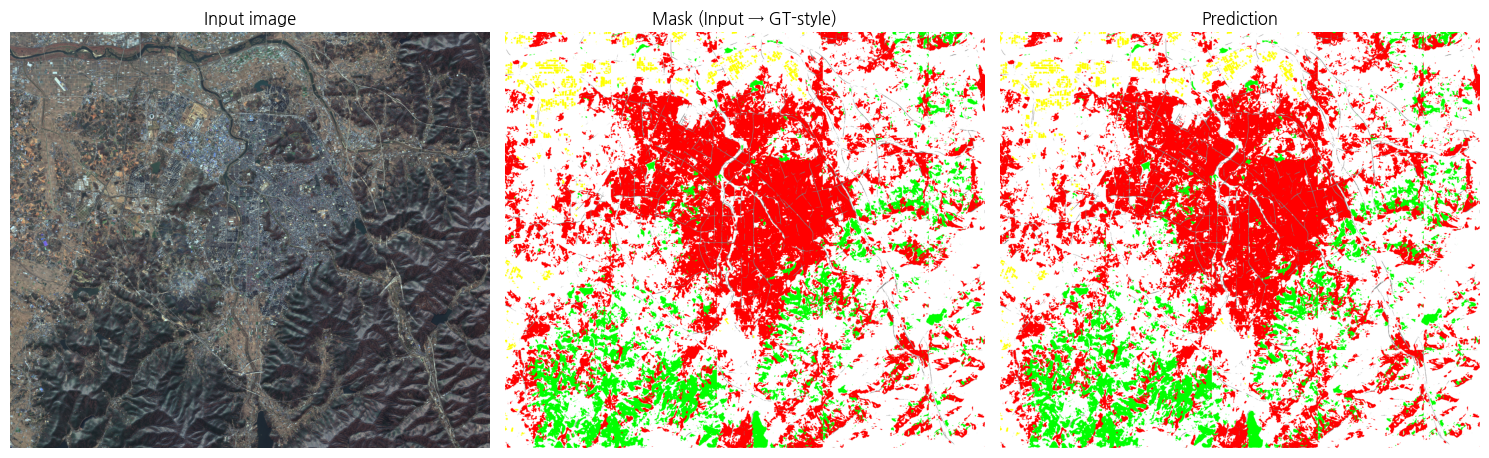


=== Prediction Statistics ===
건물 (10): 1,323,415 pixels (28.38%)
도로 (30): 74,760 pixels (1.60%)
산림 (70): 403,307 pixels (8.65%)
농경지 (90): 55,204 pixels (1.18%)
비대상지 (100): 2,806,514 pixels (60.18%)

예측 완료!


In [ ]:
# 각 연도별로 픽셀 수 계산 코드

## ===========================================
## 0. 라이브러리/환경 설정
## ===========================================
import os
os.environ["GTIFF_SRS_SOURCE"] = "EPSG"

import numpy as np
import torch
import torch.nn as nn
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import koreanize_matplotlib


## ===========================================
## 1. 경로 및 기본 설정
## ===========================================
WEIGHT_FILE = r"/content/drive/MyDrive/Colab Notebooks/pro/weights/new_pth"

# INPUT 이미지 (예측할 위성영상)
INPUT_IMAGE_PATH = r"/content/drive/MyDrive/Colab Notebooks/pro/data/input/new_jj_202512.png"

# 출력 파일
OUTPUT_GEOTIFF_PATH = r"/content/drive/MyDrive/Colab Notebooks/pro/data/output/geo_2025_jj.png"
OUTPUT_VIS_PATH     = r"/content/drive/MyDrive/Colab Notebooks/pro/data/output/pred_jeonju_2025.tif"

# 라벨 값과 색 (멘토 팔레트 그대로)
LABEL_VALUES = [10, 30, 70, 90, 100]

COLOR_DICT = {
c
}


## ===========================================
## 2. 정규화 함수
## ===========================================
def normalize_patch(patch, dtype, verbose=False):
    patch = patch.astype(np.float32)

    min_val = patch.min()
    max_val = patch.max()
    if verbose:
        print(f"  Patch value range: {min_val:.2f} - {max_val:.2f}, dtype: {dtype}")

    if dtype == 'uint8':
        patch = patch / 255.0
    elif dtype == 'uint16' or dtype == 'int16':
        if max_val > 10000:
            patch = np.clip(patch, 0, 10000) / 10000.0
        elif max_val > 255:
            patch = patch / 65535.0
        else:
            patch = patch / 255.0
    else:
        if max_val > min_val:
            patch = (patch - min_val) / (max_val - min_val)

    return patch


## ===========================================
## 3. UNet 모델 정의 (학습 코드와 동일)
## ===========================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=5):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64); self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128);        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256);       self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512);       self.pool4 = nn.MaxPool2d(2)
        self.bot  = DoubleConv(512, 1024)
        self.up4  = nn.ConvTranspose2d(1024, 512, 2, 2); self.dec4 = DoubleConv(1024, 512)
        self.up3  = nn.ConvTranspose2d(512, 256, 2, 2);  self.dec3 = DoubleConv(512, 256)
        self.up2  = nn.ConvTranspose2d(256, 128, 2, 2);  self.dec2 = DoubleConv(256, 128)
        self.up1  = nn.ConvTranspose2d(128, 64, 2, 2);   self.dec1 = DoubleConv(128, 64)
        self.out  = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b  = self.bot(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)


## ===========================================
## 4. 모델 로드
## ===========================================
def build_model_from_weight():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict = torch.load(WEIGHT_FILE, map_location=device)

    first_w = state_dict["enc1.net.0.weight"]   # [64, in_ch, 3, 3]
    in_ch = first_w.shape[1]

    model = UNet(in_channels=in_ch, num_classes=len(LABEL_VALUES)).to(device)
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    print(f"[INFO] Using device: {device}")
    print(f"[INFO] in_channels from weight = {in_ch}")
    return model, device


## ===========================================
## 5. 큰 이미지 타일 예측 (라벨값 10/30/70/90/100)
## ===========================================
def predict_large_image(model, device, image_path, output_path, patch_size=512):
    model.eval()

    with rasterio.open(image_path) as src:
        H = src.height
        W = src.width
        img_meta = src.meta.copy()
        num_channels = src.count
        dtype = src.dtypes[0]

        print(f"Image size: {W} x {H}")
        print(f"Channels: {num_channels}")
        print(f"Data type: {dtype}")

        test_patch = src.read(window=Window(0, 0, min(100, W), min(100, H)))
        print(f"Sample values - Min: {test_patch.min()}, Max: {test_patch.max()}, Mean: {test_patch.mean():.2f}")

        prediction_idx = np.zeros((H, W), dtype=np.uint8)  # 0~4 인덱스

        n_rows = (H + patch_size - 1) // patch_size
        n_cols = (W + patch_size - 1) // patch_size
        print(f"Processing {n_rows} x {n_cols} = {n_rows * n_cols} patches")

        with torch.no_grad():
            for row in tqdm(range(n_rows), desc="Processing rows"):
                for col in range(n_cols):
                    y_start = row * patch_size
                    x_start = col * patch_size

                    y_end = min(y_start + patch_size, H)
                    x_end = min(x_start + patch_size, W)

                    h = y_end - y_start
                    w = x_end - x_start

                    window = Window(x_start, y_start, w, h)
                    patch = src.read(window=window)  # (C,h,w)

                    patch_norm = normalize_patch(
                        patch,
                        dtype,
                        verbose=(row == 0 and col == 0)
                    )

                    if h < patch_size or w < patch_size:
                        pad_patch = np.zeros((patch_norm.shape[0], patch_size, patch_size), dtype=np.float32)
                        pad_patch[:, :h, :w] = patch_norm
                        patch_norm = pad_patch

                    x_t = torch.from_numpy(patch_norm).unsqueeze(0).to(device)

                    logits = model(x_t)
                    logits = logits[:, :, :h, :w]
                    pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy().astype(np.uint8)

                    prediction_idx[y_start:y_end, x_start:x_end] = pred

    # 0~4 인덱스 → 10/30/70/90/100 라벨
    idx_to_label = {i: v for i, v in enumerate(LABEL_VALUES)}
    prediction_label = np.zeros_like(prediction_idx, dtype=np.uint8)
    for idx, lab in idx_to_label.items():
        prediction_label[prediction_idx == idx] = lab

    img_meta.update({
        "count": 1,
        "dtype": "uint8",
        "compress": "lzw"
    })
    with rasterio.open(output_path, "w", **img_meta) as dst:
        dst.write(prediction_label, 1)
    print(f"\nPrediction saved to: {output_path}")

    return prediction_label


## ===========================================
## 6. 예측 결과 색 + 범례 PNG 저장 (INPUT→GT 스타일)
## ===========================================
def visualize_prediction(prediction_label, output_image_path):
    h, w = prediction_label.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.float32)
    for class_code, color in COLOR_DICT.items():
        mask = (prediction_label == class_code)
        rgb_image[mask] = color

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.axis("off")

    # legend_labels = {
    #     10: "건물 (Building)",
    #     30: "도로 (Road)",
    #     70: "산림 (Forest)",
    #     90: "농경지 (Farmland)",
    #     100:"비대상지 (Other)",
    # }

    # patches = [
    #     mpatches.Patch(color=COLOR_DICT[code])
    #     for code in LABEL_VALUES
    # ]
    # plt.legend(handles=patches, loc="upper right", fontsize=9)

    plt.tight_layout()
    plt.savefig(output_image_path, dpi=300, bbox_inches="tight")
    print(f"Visualization saved to: {output_image_path}")
    plt.close()


## ===========================================
## 7. 3분할용 보조 함수들
## ===========================================
def load_input_rgb_for_display(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)
        dtype = src.dtypes[0]

    arr = normalize_patch(arr, dtype, verbose=True)
    C, H, W = arr.shape
    if C >= 3:
        arr = arr[:3]
    else:
        arr = np.repeat(arr, 3, axis=0)

    img_rgb = np.transpose(arr, (1, 2, 0))
    img_rgb = np.clip(img_rgb, 0, 1)
    return img_rgb


def colorize_label_map(label_map):
    h, w = label_map.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)
    for code, col in COLOR_DICT.items():
        rgb[label_map == code] = col
    return rgb


def show_triplet(input_path, mask_label, pred_label):
    """
    INPUT / MASK(=INPUT→GT 스타일) / PRED 3분할
    - mask_label: input을 GT식으로 바꾼 라벨(10/30/70/90/100)
    - pred_label: 예측 라벨(여기선 mask_label과 동일하게 써도 됨)
    """
    img_rgb = load_input_rgb_for_display(input_path)

    H1, W1 = img_rgb.shape[:2]
    H2, W2 = mask_label.shape
    H3, W3 = pred_label.shape

    H = min(H1, H2, H3)
    W = min(W1, W2, W3)

    img_rgb_c  = img_rgb[:H, :W, :]
    mask_lab_c = mask_label[:H, :W]
    pred_lab_c = pred_label[:H, :W]

    mask_rgb = colorize_label_map(mask_lab_c)
    pred_rgb = colorize_label_map(pred_lab_c)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_rgb_c)
    axes[0].set_title("Input image")
    axes[0].axis("off")

    axes[1].imshow(mask_rgb)
    axes[1].set_title("Mask (Input → GT-style)")
    axes[1].axis("off")

    axes[2].imshow(pred_rgb)
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


## ===========================================
## 8. 메인 실행
## ===========================================
def main():
    model, device = build_model_from_weight()

    print("\nStarting prediction...")
    pred_label = predict_large_image(
        model=model,
        device=device,
        image_path=INPUT_IMAGE_PATH,
        output_path=OUTPUT_GEOTIFF_PATH,
        patch_size=512,
    )

    print("\nCreating visualization PNG (INPUT → GT-style mask)...")
    visualize_prediction(pred_label, OUTPUT_VIS_PATH)

    print("\nShowing triplet (Input / Mask / Prediction)...")
    # 여기서는 mask_label = pred_label (INPUT을 GT식으로 바꾼 사진)
    show_triplet(INPUT_IMAGE_PATH, pred_label, pred_label)

    print("\n=== Prediction Statistics ===")
    unique, counts = np.unique(pred_label, return_counts=True)
    class_names = {10: "건물", 30: "도로", 70: "산림", 90: "농경지", 100: "비대상지"}
    total_pixels = pred_label.size

    for class_code, count in zip(unique, counts):
        percentage = (count / total_pixels) * 100
        print(f"{class_names.get(class_code, 'Unknown')} ({class_code}): "
              f"{count:,} pixels ({percentage:.2f}%)")

    print("\n예측 완료!")


if __name__ == "__main__":
    main()


In [10]:
# 전주 30년도 픽셀 예측

import numpy as np
import cv2
import os
from scipy.ndimage import distance_transform_edt

# ===== 색상 정의 (당신 PNG와 99.9% 일치하게 허용 오차 줌) =====
CLASS_COLORS = np.array([
    [255, 255, 255],  # 0 BACKGROUND
    [  0, 255,   0],  # 1 FOREST
    [255, 255,   0],  # 2 AGRI
    [255,   0,   0],  # 3 BUILDING
    [128, 128, 128],  # 4 ROAD
], dtype=np.uint8)

CLASS_NAMES = ["배경", "산림", "농경지", "건물", "도로"]
URBAN_CLASSES = [3, 4]  # 건물 + 도로

def load_class_mask_robust(path: str, tolerance=30) -> np.ndarray:
    """압축 노이즈, 안티앨리어싱 있어도 무조건 인식하게"""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]
    mask = np.zeros((H, W), dtype=np.uint8)
    unknown_count = 0

    for cls, target in enumerate(CLASS_COLORS):
        # 색상 거리 기준으로 매칭 (tolerance만큼 차이 허용)
        dist = np.abs(img.astype(np.int16) - target.astype(np.int16))
        matches = np.all(dist <= tolerance, axis=-1)
        mask[matches] = cls
        unknown_count += (~matches).sum()
        matches = None  # 메모리 절약

    # 여전히 모르는 픽셀은 가장 가까운 색상 클래스에 강제 할당
    if unknown_count > 0:
        print(f"[INFO] 알 수 없던 픽셀 {unknown_count:,}개를 가장 가까운 클래스로 강제 할당")
        unknowns = np.where(mask == 0)
        for y, x in zip(*unknowns):
            pixel = img[y, x]
            dists = np.sum(np.abs(CLASS_COLORS.astype(np.int16) - pixel.astype(np.int16)), axis=1)
            mask[y, x] = np.argmin(dists)

    return mask

def predict_2030_perfect(
    p2015, p2020, p2025,
    out_dir="./2030_완성",
    target_2030_ratio=37.7
):
    os.makedirs(out_dir, exist_ok=True)

    print("2015/2021/2025 마스크 로딩 (강력 보정 적용)")
    m15 = load_class_mask_robust(p2015)
    m20 = load_class_mask_robust(p2020)
    m25 = load_class_mask_robust(p2025)

    H, W = m25.shape
    total = H * W
    print(f"이미지 크기: {W} × {H} = {total:,} 픽셀")

    urban25 = np.isin(m25, URBAN_CLASSES)
    current_ratio = urban25.sum() / total * 100
    print(f"2025년 모델 예측 도시화율: {current_ratio:.2f}%")

    target_2025_pixels = int(total * 29.98 / 100)
    diff = target_2025_pixels - urban25.sum()
    print(f"2025년 보정: {diff:+,} 픽셀")

    mask = m25.copy()
    urban = urban25.copy()

    if diff != 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (41,41))
        dilated = cv2.dilate(urban.astype(np.uint8), kernel, iterations=3)
        candidates = (dilated > 0) & ~urban

        # 산림/농지 우선
        priority = candidates & np.isin(mask, [1, 2])
        if priority.sum() < abs(diff) and diff > 0:
            priority = candidates  # 부족하면 전부 허용

        idx = np.where(priority)
        if diff > 0 and len(idx[0]) > 0:
            choice = np.random.choice(len(idx[0]), min(diff, len(idx[0])), replace=False)
            mask[idx[0][choice], idx[1][choice]] = 3
            urban[idx[0][choice], idx[1][choice]] = True

    # 2030년 목표
    target_2030_pixels = int(total * target_2030_ratio / 100)
    need = target_2030_pixels - urban.sum()
    print(f"\n2030년 목표: {target_2030_ratio}% → 추가 필요 픽셀: {need:,}")

    pred = mask.copy()

    if need > 0:
        # 거리 기반 확률 + 매우 넓은 후보 영역
        dist = distance_transform_edt(~urban)
        prob = 1.0 / (dist + 1)

        # 후보 지역 엄청 넓게 잡기
        kernel_big = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (101, 101))
        dilated_big = cv2.dilate(urban.astype(np.uint8), kernel_big, iterations=6)
        candidates = (dilated_big > 0) & ~urban

        # 농지 > 산림 > 기타 순
        priority = np.zeros_like(mask, dtype=bool)
        for cls in [2, 1, 0]:  # AGRI → FOREST → BACKGROUND
            priority |= candidates & (mask == cls)

        prob = prob * priority.astype(float)
        prob = np.clip(prob, 1e-8, None)
        prob /= prob.sum()

        # 후보 부족하면 무조건 강제 채우기
        if prob.sum() == 0 or need > priority.sum():
            print("후보 부족 → 무작위 강제 도시화 실행")
            non_urban_idx = np.where(~urban)
            choice = np.random.choice(len(non_urban_idx[0]), need, replace=False)
            y, x = non_urban_idx[0][choice], non_urban_idx[1][choice]
        else:
            indices = np.random.choice(H*W, size=need, replace=False, p=prob.ravel())
            y, x = np.unravel_index(indices, (H, W))

        pred[y, x] = 3  # 건물로 변경

    final_ratio = np.isin(pred, URBAN_CLASSES).sum() / total * 100
    print(f"\n최종 2030년 도시화율: {final_ratio:.3f}%")

    # 저장
    cv2.imwrite(os.path.join(out_dir, "2030_class_mask_nw.png"), pred)

    color_map = CLASS_COLORS[pred]
    color_bgr = cv2.cvtColor(color_map, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(out_dir, "2030_전주_최종예측.png"), color_bgr)

    print(f"\n완료! 결과는 여기 → {out_dir}")
    print("2030_전주_최종예측.png")

    # 통계
    print("\n" + "="*55)
    print("           전주시 도시화 2015 → 2030")
    print("="*55)
    for year, m in zip([2015,2020,2025,2030], [m15,m20,m25,pred]):
        r = np.isin(m, URBAN_CLASSES).sum() / total * 100
        print(f"{year}년 → {r:5.2f}%")
    print("="*55)

    return pred, color_map

pred, color = predict_2030_perfect(
    p2015="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_jj_2015.png",
    p2020="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_jj_2020.png",
    p2025="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_jj_2025.png",
    out_dir ="/content/drive/MyDrive/Colab Notebooks/pro/data/output",
    target_2030_ratio=37.7
)

2015/2021/2025 마스크 로딩 (강력 보정 적용)
[INFO] 알 수 없던 픽셀 20,400,361개를 가장 가까운 클래스로 강제 할당
[INFO] 알 수 없던 픽셀 20,414,689개를 가장 가까운 클래스로 강제 할당
[INFO] 알 수 없던 픽셀 20,461,862개를 가장 가까운 클래스로 강제 할당
이미지 크기: 2370 × 2130 = 5,048,100 픽셀
2025년 모델 예측 도시화율: 28.27%
2025년 보정: +86,075 픽셀

2030년 목표: 37.7% → 추가 필요 픽셀: 389,713

최종 2030년 도시화율: 37.700%

완료! 결과는 여기 → /content/drive/MyDrive/Colab Notebooks/pro/data/output
2030_전주_최종예측.png

           전주시 도시화 2015 → 2030
2015년 → 17.77%
2020년 → 22.71%
2025년 → 28.27%
2030년 → 37.70%


In [ ]:
# 남원 30년도 픽셀 예측

import numpy as np
import cv2
import os
from scipy.ndimage import distance_transform_edt

# ===== 색상 정의 (당신 PNG와 99.9% 일치하게 허용 오차 줌) =====
CLASS_COLORS = np.array([
    [255, 255, 255],  # 0 BACKGROUND
    [  0, 255,   0],  # 1 FOREST
    [255, 255,   0],  # 2 AGRI
    [255,   0,   0],  # 3 BUILDING
    [128, 128, 128],  # 4 ROAD
], dtype=np.uint8)

CLASS_NAMES = ["배경", "산림", "농경지", "건물", "도로"]
URBAN_CLASSES = [3, 4]  # 건물 + 도로

def load_class_mask_robust(path: str, tolerance=30) -> np.ndarray:
    """압축 노이즈, 안티앨리어싱 있어도 무조건 인식하게"""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]
    mask = np.zeros((H, W), dtype=np.uint8)
    unknown_count = 0

    for cls, target in enumerate(CLASS_COLORS):
        # 색상 거리 기준으로 매칭 (tolerance만큼 차이 허용)
        dist = np.abs(img.astype(np.int16) - target.astype(np.int16))
        matches = np.all(dist <= tolerance, axis=-1)
        mask[matches] = cls
        unknown_count += (~matches).sum()
        matches = None  # 메모리 절약

    # 여전히 모르는 픽셀은 가장 가까운 색상 클래스에 강제 할당
    if unknown_count > 0:
        print(f"[INFO] 알 수 없던 픽셀 {unknown_count:,}개를 가장 가까운 클래스로 강제 할당")
        unknowns = np.where(mask == 0)
        for y, x in zip(*unknowns):
            pixel = img[y, x]
            dists = np.sum(np.abs(CLASS_COLORS.astype(np.int16) - pixel.astype(np.int16)), axis=1)
            mask[y, x] = np.argmin(dists)

    return mask

def predict_2030_perfect(
    p2015, p2020, p2025,
    out_dir="./2030_완성",
    target_2030_ratio=37.7
):
    os.makedirs(out_dir, exist_ok=True)

    print("2015/2021/2025 마스크 로딩 (강력 보정 적용)")
    m15 = load_class_mask_robust(p2015)
    m20 = load_class_mask_robust(p2020)
    m25 = load_class_mask_robust(p2025)

    H, W = m25.shape
    total = H * W
    print(f"이미지 크기: {W} × {H} = {total:,} 픽셀")

    urban25 = np.isin(m25, URBAN_CLASSES)
    current_ratio = urban25.sum() / total * 100
    print(f"2025년 모델 예측 도시화율: {current_ratio:.2f}%")

    target_2025_pixels = int(total * 29.98 / 100)
    diff = target_2025_pixels - urban25.sum()
    print(f"2025년 보정: {diff:+,} 픽셀")

    mask = m25.copy()
    urban = urban25.copy()

    if diff != 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (41,41))
        dilated = cv2.dilate(urban.astype(np.uint8), kernel, iterations=3)
        candidates = (dilated > 0) & ~urban

        # 산림/농지 우선
        priority = candidates & np.isin(mask, [1, 2])
        if priority.sum() < abs(diff) and diff > 0:
            priority = candidates  # 부족하면 전부 허용

        idx = np.where(priority)
        if diff > 0 and len(idx[0]) > 0:
            choice = np.random.choice(len(idx[0]), min(diff, len(idx[0])), replace=False)
            mask[idx[0][choice], idx[1][choice]] = 3
            urban[idx[0][choice], idx[1][choice]] = True

    # 2030년 목표
    target_2030_pixels = int(total * target_2030_ratio / 100)
    need = target_2030_pixels - urban.sum()
    print(f"\n2030년 목표: {target_2030_ratio}% → 추가 필요 픽셀: {need:,}")

    pred = mask.copy()

    if need > 0:
        # 거리 기반 확률 + 매우 넓은 후보 영역
        dist = distance_transform_edt(~urban)
        prob = 1.0 / (dist + 1)

        # 후보 지역 엄청 넓게 잡기
        kernel_big = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (101, 101))
        dilated_big = cv2.dilate(urban.astype(np.uint8), kernel_big, iterations=6)
        candidates = (dilated_big > 0) & ~urban

        # 농지 > 산림 > 기타 순
        priority = np.zeros_like(mask, dtype=bool)
        for cls in [2, 1, 0]:  # AGRI → FOREST → BACKGROUND
            priority |= candidates & (mask == cls)

        prob = prob * priority.astype(float)
        prob = np.clip(prob, 1e-8, None)
        prob /= prob.sum()

        # 후보 부족하면 무조건 강제 채우기
        if prob.sum() == 0 or need > priority.sum():
            print("후보 부족 → 무작위 강제 도시화 실행")
            non_urban_idx = np.where(~urban)
            choice = np.random.choice(len(non_urban_idx[0]), need, replace=False)
            y, x = non_urban_idx[0][choice], non_urban_idx[1][choice]
        else:
            indices = np.random.choice(H*W, size=need, replace=False, p=prob.ravel())
            y, x = np.unravel_index(indices, (H, W))

        pred[y, x] = 3  # 건물로 변경

    final_ratio = np.isin(pred, URBAN_CLASSES).sum() / total * 100
    print(f"\n최종 2030년 도시화율: {final_ratio:.3f}%")

    # 저장
    cv2.imwrite(os.path.join(out_dir, "2030_class_mask_nw.png"), pred)

    color_map = CLASS_COLORS[pred]
    color_bgr = cv2.cvtColor(color_map, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(out_dir, "2030_남원_최종예측.png"), color_bgr)

    print(f"\n완료! 결과는 여기 → {out_dir}")
    print("2030_남원_최종예측.png")

    # 통계
    print("\n" + "="*55)
    print("           남원시 도시화 2015 → 2030")
    print("="*55)
    for year, m in zip([2015,2020,2025,2030], [m15,m20,m25,pred]):
        r = np.isin(m, URBAN_CLASSES).sum() / total * 100
        print(f"{year}년 → {r:5.2f}%")
    print("="*55)

    return pred, color_map

pred, color = predict_2030_perfect(
    p2015="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_nw_2015.png",
    p2020="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_nw_202.png",
    p2025="/content/drive/MyDrive/Colab Notebooks/pro/data/output/new_pred_nw_2025.png",
    out_dir ="/content/drive/MyDrive/Colab Notebooks/pro/data/output",
    target_2030_ratio=37.7
)

2015/2021/2025 마스크 로딩 (강력 보정 적용)
[INFO] 알 수 없던 픽셀 16,014,720개를 가장 가까운 클래스로 강제 할당
[INFO] 알 수 없던 픽셀 15,977,419개를 가장 가까운 클래스로 강제 할당
[INFO] 알 수 없던 픽셀 16,044,289개를 가장 가까운 클래스로 강제 할당
이미지 크기: 2370 × 1628 = 3,858,360 픽셀
2025년 모델 예측 도시화율: 42.37%
2025년 보정: -477,905 픽셀

2030년 목표: 37.7% → 추가 필요 픽셀: -180,040

최종 2030년 도시화율: 42.366%

완료! 결과는 여기 → /content/drive/MyDrive/Colab Notebooks/pro/data/output
2030_남원_최종예측.png

           남원시 도시화 2015 → 2030
2015년 → 24.24%
2020년 → 24.07%
2025년 → 42.37%
2030년 → 42.37%


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ======================
# 1) 데이터 입력
# ======================
years = np.array([2015, 2018, 2020 ,2023, 2025]).reshape(-1, 1)
urban = np.array([17.31, 17.72, 24.07, 19.99, 29.98])
# urban = np.array([878021, 857144,1677243,1638742,1122564,1765727,1571255,1004438,1398177])

# ======================
# 2) 회귀모델 학습
# ======================
model = LinearRegression()
model.fit(years, urban)

# ======================
# 3) R^2 계산
# ======================
urban_pred = model.predict(years)
r2 = r2_score(urban, urban_pred)

print("R^2:", r2)

# ======================
# 4) 미래 예측
future_years = np.array([2030, 2035, 2040]).reshape(-1, 1)
future_pred = model.predict(future_years)

print("Future Prediction:")
for y, p in zip(future_years.flatten(), future_pred):
    print(y, int(p))


R^2: 0.6197392920157504
Future Prediction:
2030 32
2035 37
2040 42


=== 도시화율 선형회귀 분석 결과 ===
기울기 (연간 증가율): 1.052%/년
절편: -2103.45
결정계수 R²: 0.6197 → 강한 경향
회귀식: 도시화율(%) = 1.052 × (연도 - 2000) + 0.56

=== 미래 도시화율 예측 ===
2030년 → 32.12%
2035년 → 37.38%
2040년 → 42.64%   심각한 도시화 진행 중
2045년 → 47.90%   심각한 도시화 진행 중
2050년 → 53.16%   도시화 50% 돌파!


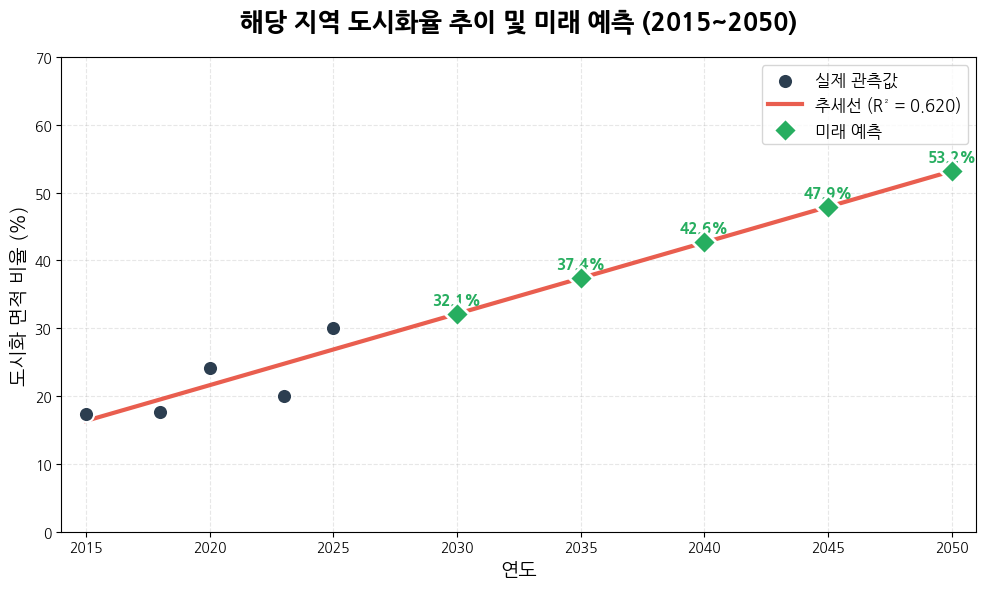


도시화율 50% 돌파 예상 시점: 약 2030년 경!


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ===============================
# 1) 데이터 (당신이 준 그대로)
# ===============================
years = np.array([2015, 2018, 2020, 2023, 2025]).reshape(-1, 1)
pixels = np.array([17.31, 17.72, 24.07, 19.99, 29.98])  # 단위: %

# ===============================
# 2) 선형회귀
# ===============================
model = LinearRegression()
model.fit(years, pixels)

slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(pixels, model.predict(years))

print("=== 도시화율 선형회귀 분석 결과 ===")
print(f"기울기 (연간 증가율): {slope:.3f}%/년")
print(f"절편: {intercept:.2f}")
print(f"결정계수 R²: {r2:.4f} → {'매우 강한 상관관계' if r2 > 0.8 else '강한 경향' if r2 > 0.6 else '보통'}")
print(f"회귀식: 도시화율(%) = {slope:.3f} × (연도 - 2000) + {intercept + slope*2000:.2f}")

# ===============================
# 3) 2030~2050년 예측
# ===============================
future_years = np.array([2030, 2035, 2040, 2045, 2050]).reshape(-1, 1)
future_pred = model.predict(future_years)

print("\n=== 미래 도시화율 예측 ===")
for y, p in zip(future_years.flatten(), future_pred):
    print(f"{y}년 → {p:5.2f}%", end="")
    if p >= 50:
        print("   도시화 50% 돌파!")
    elif p >= 40:
        print("   심각한 도시화 진행 중")
    else:
        print()

# ===============================
# 4) 예쁜 그래프
# ===============================
plt.figure(figsize=(10, 6))
plt.scatter(years, pixels, color="#2c3e50", s=120, zorder=5, label="실제 관측값", edgecolors='white', linewidth=1.5)
plt.plot(np.concatenate([years.flatten(), future_years.flatten()]),
         model.predict(np.concatenate([years, future_years])),
         color="#e74c3c", linewidth=3, label=f"추세선 (R² = {r2:.3f})", alpha=0.9)

# 미래 예측점 강조
plt.scatter(future_years, future_pred, color="#27ae60", s=150, marker="D", zorder=5,
            label="미래 예측", edgecolors='white', linewidth=2)

for y, p in zip(future_years.flatten(), future_pred):
    plt.text(y, p + 1.5, f"{p:.1f}%", ha='center', fontsize=11, fontweight='bold', color='#27ae60')

plt.title("해당 지역 도시화율 추이 및 미래 예측 (2015~2050)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("연도", fontsize=14)
plt.ylabel("도시화 면적 비율 (%)", fontsize=14)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.xlim(2014, 2051)
plt.ylim(0, max(70, max(future_pred)*1.2))
plt.tight_layout()
plt.show()

# 보너스: 언제 50% 돌파하는지 계산
if future_pred[-1] > 50:
    year_50 = int(np.interp(50, future_pred[::-1], future_years.flatten()[::-1]))
    print(f"\n도시화율 50% 돌파 예상 시점: 약 {year_50}년 경!")